## Setting configs

In [1]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 400
img_shape = (299,299)
images_per_classe = 100  # use 0 for all images
BS = 64
steps = 20
reload_img = False
H = None
model = None
scores= None

In [2]:
# import the necessary packages
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet152V2 as App
from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
#from keras.utils import  to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import cv2
%matplotlib inline
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
    path = "/content/drive/My Drive/Colab Notebooks/database/"
    load_path = "/content/drive/My Drive/Colab Notebooks/"
    save_path = '/content/drive/My Drive/Colab Notebooks/trained_models/'
    drive.mount('/content/drive')
    
except:
    print("Note: not using Google CoLab")
    COLAB = False
    path = "../database/"
    save_path = 'trained_models/'
    load_path = ""

print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

Note: not using Google CoLab
2.4.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

## Load Dataset of Images

In [4]:
def train_val_test_split(df, class_labels):
    train = pd.DataFrame()
    test  = pd.DataFrame()
    val   = pd.DataFrame()
    for e in df1[class_labels].unique():
        temp = df1[df1[class_labels]==e]
        temp_train, temp_val, temp_test = np.split(temp.sample(frac=1), [int(.5*len(temp)), int(.7*len(temp))])
        train = pd.concat([train ,temp_train])
        test  = pd.concat([test ,temp_test])
        val   = pd.concat([val ,temp_val])
    return train, val, test

In [5]:
def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        file_name=[]
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            
            if img is not None:
                end=filename.find(".")
                file_name.append(file[0:end])
                images.append(img)
                
        return images, file_name
    else:
        path = []
        for filename in os.listdir(folder)[:images_per_classe]:
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [6]:
if reload_img:

  # Load the paths on the images
  images = []
  for f in os.listdir(path):
      if "jpg" in os.listdir(path+f)[0]:
          images += load_images_from_folder(path+f,True,label = f)
        
      else: 
          for d in os.listdir(path+f):
              images += load_images_from_folder(path+f+"/"+d,True,label = f)
              
                          
  # Create a dataframe with the paths and the label for each insect
  df1 = pd.DataFrame(images, columns = ["insect_gbif", "path_img"])

  file_name=[]
  for i in range(len(df1["path_img"])):
      temp=df1.path_img[i].split('/')[-1].split('.')[0]
      file_name.append(temp)
  file_name

  df1['file_name'] = file_name
  display(df1.describe())
  train, validate, test = train_val_test_split(df1,'insect_gbif')

  train.to_csv(load_path+'train.csv',index=False)
  validate.to_csv(load_path+'validate.csv',index=False)
  test.to_csv(load_path+'test.csv',index=False)

else:
  train    = pd.read_csv(load_path+'train.csv', dtype='object')
  validate = pd.read_csv(load_path+'validate.csv', dtype='object')
  test     = pd.read_csv(load_path+'test.csv', dtype='object')
  if not COLAB:
    train['path_img']    = train['path_img'].apply(lambda x: path+x.split('database/')[1])
    test['path_img']     = test['path_img'].apply(lambda x: path+x.split('database/')[1])
    validate['path_img'] = validate['path_img'].apply(lambda x: path+x.split('database/')[1])
  df1 = pd.concat([train, validate, test])
  
display(df1)

,insect_gbif,path_img,file_name
0,1035167,../database/1035167\d162s0153.jpg,1035167\d162s0153
1,1035167,../database/1035167\d162s0145.jpg,1035167\d162s0145
2,1035167,../database/1035167\d162s0120.jpg,1035167\d162s0120
3,1035167,../database/1035167\d162s0085.jpg,1035167\d162s0085
4,1035167,../database/1035167\d162s0106.jpg,1035167\d162s0106
...,...,...,...
8192,9581584,../database/9581584\d135s0010.jpg,9581584\d135s0010
8193,9581584,../database/9581584\d135s0014.jpg,9581584\d135s0014
8194,9581584,../database/9581584\d135s0097.jpg,9581584\d135s0097
8195,9581584,../database/9581584\d135s0042.jpg,9581584\d135s0042


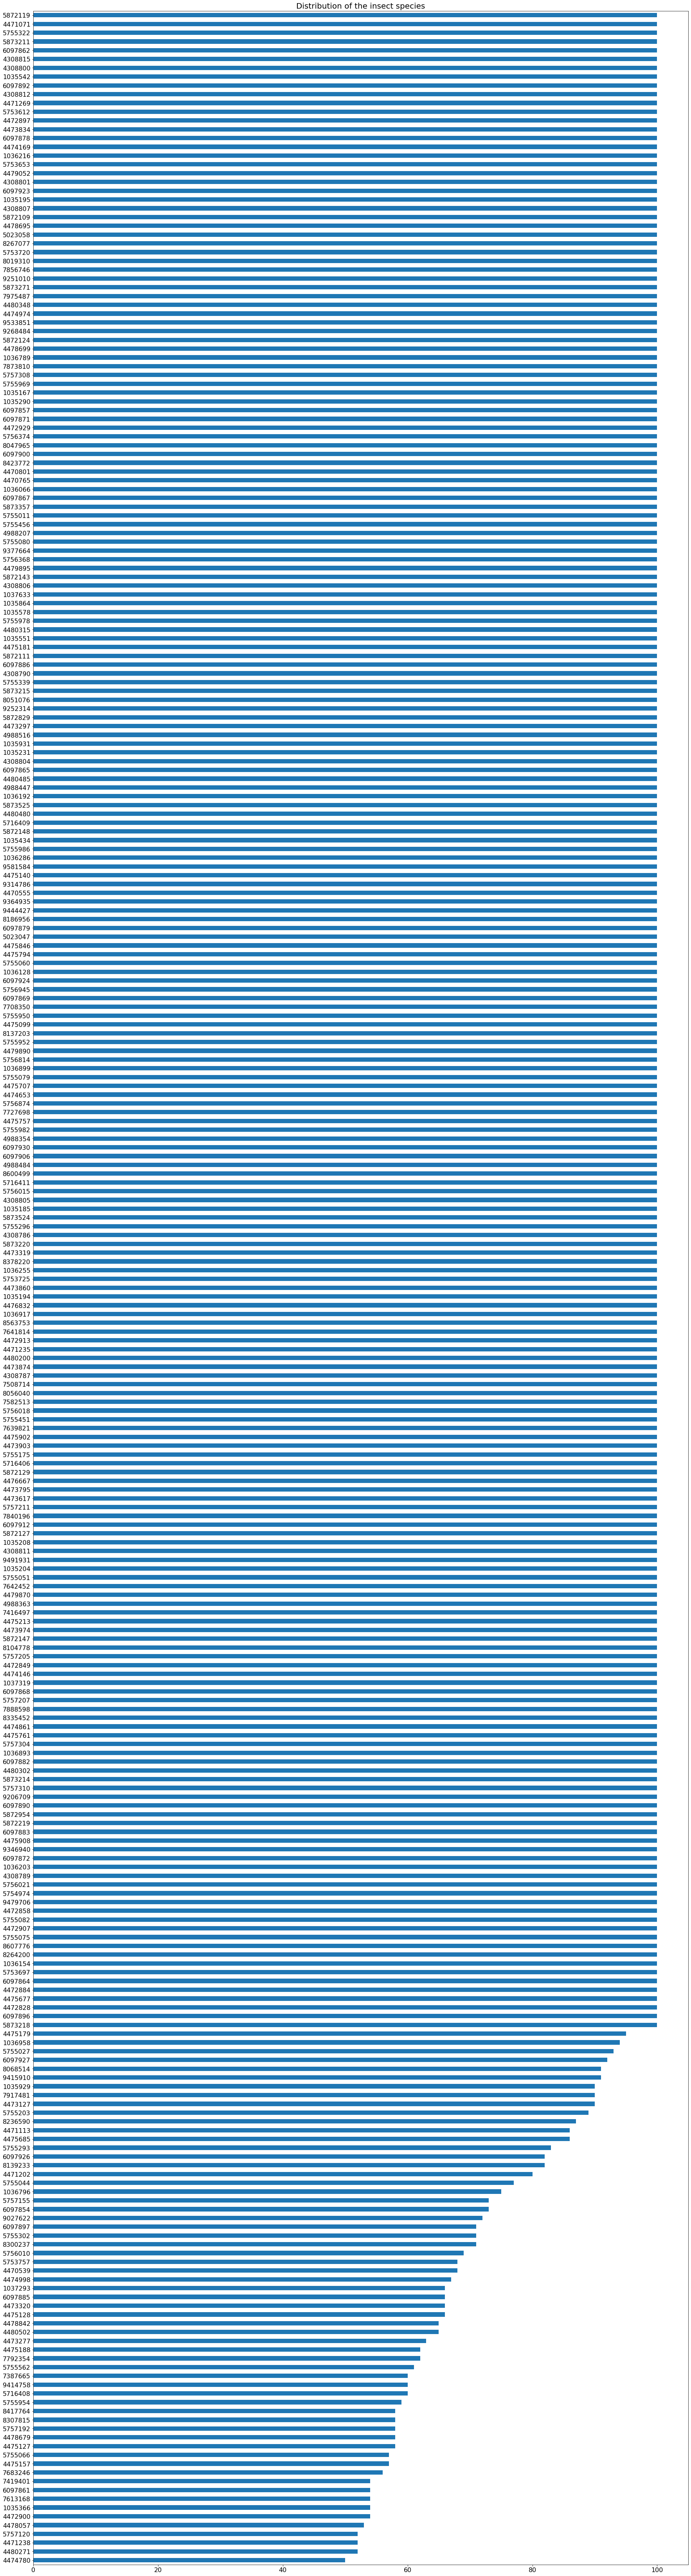

In [179]:
bar = df1["insect_gbif"].value_counts(ascending=True).plot.barh(figsize = (30,120))
plt.title("Distribution of the insect species", fontsize = 20)
bar.tick_params(labelsize=16)
plt.savefig('dis.png', dpi=100)
plt.show()

In [7]:
print(train.groupby('insect_gbif')['insect_gbif'].count().sort_values())
print(test.groupby('insect_gbif')['insect_gbif'].count().sort_values())
print(validate.groupby('insect_gbif')['insect_gbif'].count().sort_values())

insect_gbif
4474780    25
5757120    26
4480271    26
4478057    26
4471238    26
           ..
4480315    50
4480348    50
4480480    50
5755952    50
9581584    50
Name: insect_gbif, Length: 291, dtype: int64
insect_gbif
4474780    15
5757120    16
4471238    16
4480271    16
4478057    16
           ..
4480315    30
4480348    30
4480480    30
5755952    30
9581584    30
Name: insect_gbif, Length: 291, dtype: int64
insect_gbif
4474780    10
4471238    10
7613168    10
4472900    10
7419401    10
           ..
4480315    20
4480348    20
4480480    20
5755952    20
9581584    20
Name: insect_gbif, Length: 291, dtype: int64


In [8]:
display(train.describe())
display(validate.describe())
display(test.describe())

,insect_gbif,path_img,file_name
count,13601,13601,13601
unique,291,13601,13601
top,4472929,../database/4470801\d015s0056.jpg,5872148\d084s0135
freq,50,1,1


,insect_gbif,path_img,file_name
count,5428,5428,5428
unique,291,5428,5428
top,4472929,../database/8563753\d164s0055.jpg,1036255\d075s0083
freq,20,1,1


,insect_gbif,path_img,file_name
count,8197,8197,8197
unique,291,8197,8197
top,4472929,../database/1036255\d075s0070.jpg,5755044\d152s0022
freq,30,1,1


In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=10, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [70]:
train_dataset = train_datagen.flow_from_dataframe(train, x_col='path_img', y_col='insect_gbif', batch_size=BS, target_size=img_shape)
val_dataset   = val_datagen.flow_from_dataframe(validate, x_col='path_img', y_col='insect_gbif', batch_size=BS, target_size=img_shape)
test_dataset  = test_datagen.flow_from_dataframe(test, x_col='path_img', y_col='insect_gbif', batch_size=BS, shuffle=False, target_size=img_shape)

Found 13601 validated image filenames belonging to 291 classes.
Found 5428 validated image filenames belonging to 291 classes.
Found 8197 validated image filenames belonging to 291 classes.


## Display Dataset Examples

In [11]:
imgs, labs = next(train_dataset)

In [12]:
img = imgs[0]
img.shape

(299, 299, 3)

In [13]:
print(img)

[[[0.6674214  0.6862745  0.6116167 ]
  [0.6672353  0.6862745  0.6106862 ]
  [0.66704917 0.6862745  0.60975564]
  ...
  [0.5529412  0.5882353  0.5764706 ]
  [0.5529412  0.5882353  0.5820688 ]
  [0.5501465  0.58544064 0.58151907]]

 [[0.67058825 0.68777514 0.62970185]
  [0.67058825 0.6874029  0.62914354]
  [0.67058825 0.68703073 0.6285853 ]
  ...
  [0.5529412  0.5882353  0.5764706 ]
  [0.5529412  0.5882353  0.582441  ]
  [0.54996043 0.58525455 0.581333  ]]

 [[0.66984236 0.6933718  0.6384698 ]
  [0.67002857 0.693558   0.638656  ]
  [0.67021465 0.69374406 0.6388421 ]
  ...
  [0.5529412  0.5882353  0.5764706 ]
  [0.5529412  0.5882353  0.5828132 ]
  [0.54977435 0.58506846 0.5811469 ]]

 ...

 [[0.7219423  0.7454717  0.69056976]
  [0.7254902  0.7490196  0.69411767]
  [0.7254902  0.7490196  0.69411767]
  ...
  [0.7137255  0.7294118  0.6627451 ]
  [0.7137255  0.7294118  0.6627451 ]
  [0.7137255  0.7294118  0.6627451 ]]

 [[0.7221284  0.7456578  0.69075584]
  [0.7254902  0.7490196  0.69411767]


141


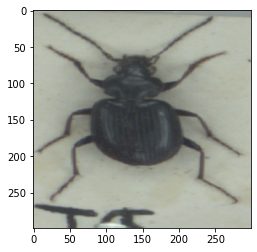

In [14]:
plt.imshow(img)
print([ np.where(r==1)[0][0] for r in labs ][0])

In [15]:
y_train= [ np.where(r==1)[0][0] for r in labs ]
print(y_train)

[141, 191, 166, 286, 45, 277, 83, 219, 260, 242, 282, 37, 239, 49, 78, 13, 183, 109, 280, 186, 192, 6, 31, 271, 246, 265, 243, 179, 234, 229, 170, 255, 239, 219, 141, 210, 198, 119, 116, 213, 210, 218, 229, 220, 125, 76, 54, 121, 102, 96]


### Display 20 picture of the TRAIN dataset with their labels

In [131]:
def get_names(x, i):
  return [ np.where(r==1)[0][0] for r in x ][i]


NameError: name 'imgs' is not defined

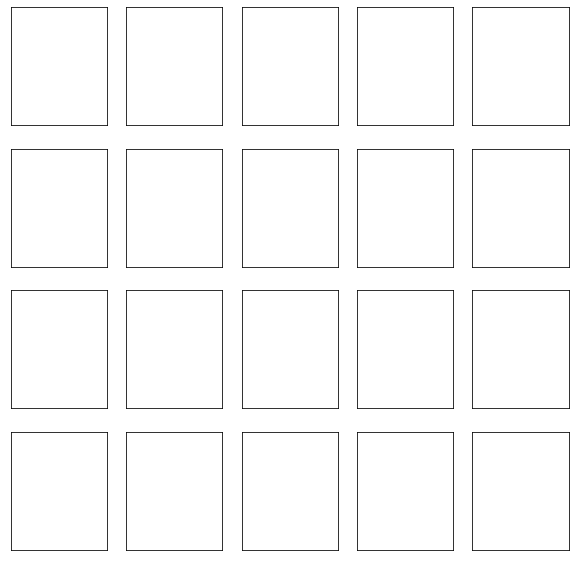

In [130]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i])
    ax.set_title(get_names(labs,i))
plt.tight_layout()
plt.show()

### Display 20 picture of the TEST dataset with their labels

In [17]:
timgs, tlabs = next(test_dataset)

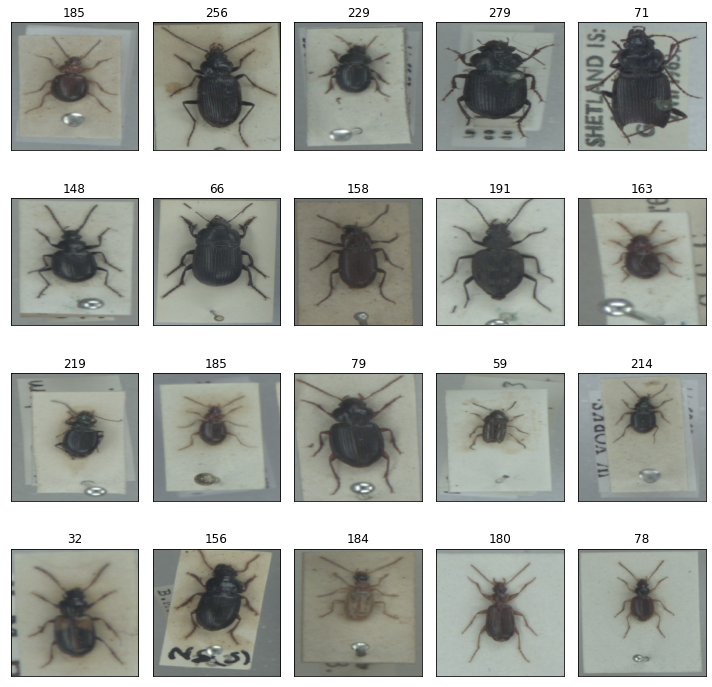

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(timgs[i])
    ax.set_title(get_names(tlabs,i))
plt.tight_layout()
plt.show()

## Build the model

In [11]:
# load the VGG16 network, ensuring the head FC layer sets are left off
def Compile_Model():
  # initialize the training data augmentation object
    global model,scores,img_shape
    scores = None
    app = App(weights="imagenet", include_top=False,input_tensor=Input(shape=(img_shape[0], img_shape[1], 3)))
    for layer in app.layers:
        layer.trainable = False
    initial_model = Sequential(app)
   # initial_model.add(Conv2D(124, kernel_size =(5,5), activation='relu', data_format='channels_last', padding='same', name='MyConv_1'))
    initial_model.add(MaxPooling2D(pool_size=(2,2), name='MyMaxpool_1'))
    #initial_model.add(Conv2D(124, kernel_size =(5,5), activation='relu', data_format='channels_last', padding='same', name='MyConv_2'))#lite
 #   initial_model.add(Conv2D(248, kernel_size =(5,5), activation='relu', data_format='channels_last', padding='same', name='MyConv_2'))#power
    initial_model.add(Flatten())

#    initial_model.add(Dense(2048, activation='relu')) #power
    initial_model.add(Dense(1024, activation='relu'))  #lite 
    initial_model.add(Dense(1024, activation='relu'))  #lite 
    initial_model.add(Dense(1024, activation='relu')) 
    #initial_model.add(Dense(582, activation='relu')) 
    initial_model.add(Dense(291, activation='softmax'))  

    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    initial_model.compile( loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model = initial_model
  

## Training the model

In [12]:
# train the head of the network
def Train_Model(train_data, val_data, epochs):
  global model,scores,steps,save_path
  early_stop = EarlyStopping(monitor="val_loss", min_delta=0.001, verbose=0, mode="min",patience=20)
  checkpoint = ModelCheckpoint(save_path+'best_model(ResNetv2).h5', monitor="val_loss", verbose=0, save_best_only=True, mode="min")
 # scores = model.fit_generator(train_data,validation_data=val_data, steps_per_epoch=steps, validation_steps=steps, epochs=epochs,callbacks=[early_stop,checkpoint])
  scores = model.fit_generator(train_data,validation_data=val_data, steps_per_epoch=steps, validation_steps=steps, epochs=epochs,callbacks=[checkpoint])
  return scores

## Test the model

In [13]:
# make predictions on the testing set
def Evaluate_Model(dataset):
  global model,scores
  if scores != None:
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    ax.plot(scores.history["val_loss"])
    ax.set_title("loss")
    ax.set_xlabel("epochs")

    ax2 = fig.add_subplot(122)
    ax2.plot(scores.history["val_accuracy"])
    ax2.set_title("validation accuracy")
    ax2.set_xlabel("epochs")
    ax2.set_ylim(0, 1)
    plt.show()
  loss, acc = model.evaluate_generator(dataset)
  print(f'Loss: {loss} ::::::::> Acc: {acc}')


In [14]:
def Execute_Model():
  global train_dataset, val_dataset,EPOCHS,model,test_dataset
  print('Compilar')
  Compile_Model() 
  print('Pré-teste')
  #Evaluate_Model(test_dataset) 
  print('Treinar')
  Train_Model(train_dataset,val_dataset,EPOCHS)
  print('Pós-teste')
  Evaluate_Model(test_dataset) 

## Execute Model

Compilar
Pré-teste
Treinar


C:\Users\josed\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/400
20/20 [==============================] - 71s 3s/step - loss: 18.5996 - accuracy: 0.0084 - val_loss: 5.8687 - val_accuracy: 0.0117
Epoch 2/400
20/20 [==============================] - 54s 3s/step - loss: 5.6459 - accuracy: 0.0216 - val_loss: 5.3319 - val_accuracy: 0.0391
Epoch 3/400
20/20 [==============================] - 56s 3s/step - loss: 5.2416 - accuracy: 0.0326 - val_loss: 4.8935 - val_accuracy: 0.0578
Epoch 4/400
20/20 [==============================] - 54s 3s/step - loss: 4.8600 - accuracy: 0.0476 - val_loss: 4.5430 - val_accuracy: 0.0688
Epoch 5/400
20/20 [==============================] - 54s 3s/step - loss: 4.4640 - accuracy: 0.0793 - val_loss: 4.1763 - val_accuracy: 0.0914
Epoch 6/400
20/20 [==============================] - 54s 3s/step - loss: 3.9903 - accuracy: 0.1381 - val_loss: 3.9262 - val_accuracy: 0.1250
Epoch 7/400
20/20 [==============================] - 54s 3s/step - loss: 3.7680 - accuracy: 0.1325 - val_loss: 3.6464 - val_accuracy: 0.1492
Epoch 8/400


Epoch 59/400
20/20 [==============================] - 56s 3s/step - loss: 1.0883 - accuracy: 0.6772 - val_loss: 2.1021 - val_accuracy: 0.4703
Epoch 60/400
20/20 [==============================] - 56s 3s/step - loss: 1.2365 - accuracy: 0.6359 - val_loss: 2.0818 - val_accuracy: 0.4711
Epoch 61/400
20/20 [==============================] - 56s 3s/step - loss: 1.0479 - accuracy: 0.6717 - val_loss: 2.1626 - val_accuracy: 0.4602
Epoch 62/400
20/20 [==============================] - 56s 3s/step - loss: 1.0823 - accuracy: 0.6710 - val_loss: 1.9253 - val_accuracy: 0.4945
Epoch 63/400
20/20 [==============================] - 57s 3s/step - loss: 0.9767 - accuracy: 0.7185 - val_loss: 2.1175 - val_accuracy: 0.4758
Epoch 64/400
20/20 [==============================] - 56s 3s/step - loss: 1.0885 - accuracy: 0.6646 - val_loss: 2.0004 - val_accuracy: 0.5039
Epoch 65/400
20/20 [==============================] - 56s 3s/step - loss: 1.1341 - accuracy: 0.6460 - val_loss: 2.0922 - val_accuracy: 0.5000
Epoch 

20/20 [==============================] - 54s 3s/step - loss: 0.4769 - accuracy: 0.8549 - val_loss: 2.2955 - val_accuracy: 0.5445
Epoch 174/400
20/20 [==============================] - 54s 3s/step - loss: 0.6451 - accuracy: 0.8128 - val_loss: 2.3800 - val_accuracy: 0.5125
Epoch 175/400
20/20 [==============================] - 54s 3s/step - loss: 0.5589 - accuracy: 0.8223 - val_loss: 2.3578 - val_accuracy: 0.5312
Epoch 176/400
20/20 [==============================] - 56s 3s/step - loss: 0.5538 - accuracy: 0.8441 - val_loss: 2.0406 - val_accuracy: 0.5672
Epoch 177/400
20/20 [==============================] - 54s 3s/step - loss: 0.5354 - accuracy: 0.8450 - val_loss: 2.2320 - val_accuracy: 0.5437
Epoch 178/400
20/20 [==============================] - 54s 3s/step - loss: 0.6097 - accuracy: 0.8145 - val_loss: 2.1700 - val_accuracy: 0.5469
Epoch 179/400
20/20 [==============================] - 55s 3s/step - loss: 0.5821 - accuracy: 0.8276 - val_loss: 2.2253 - val_accuracy: 0.5289
Epoch 180/400

20/20 [==============================] - 54s 3s/step - loss: 0.4662 - accuracy: 0.8525 - val_loss: 2.6466 - val_accuracy: 0.5492
Epoch 288/400
20/20 [==============================] - 54s 3s/step - loss: 0.4591 - accuracy: 0.8595 - val_loss: 2.4861 - val_accuracy: 0.5469
Epoch 289/400
20/20 [==============================] - 54s 3s/step - loss: 0.3792 - accuracy: 0.8812 - val_loss: 2.7287 - val_accuracy: 0.5422
Epoch 290/400
20/20 [==============================] - 54s 3s/step - loss: 0.4483 - accuracy: 0.8813 - val_loss: 2.7499 - val_accuracy: 0.5375
Epoch 291/400
20/20 [==============================] - 54s 3s/step - loss: 0.5160 - accuracy: 0.8550 - val_loss: 2.5006 - val_accuracy: 0.5344
Epoch 292/400
20/20 [==============================] - 54s 3s/step - loss: 0.4403 - accuracy: 0.8711 - val_loss: 2.4116 - val_accuracy: 0.5477
Epoch 293/400
20/20 [==============================] - 54s 3s/step - loss: 0.4180 - accuracy: 0.8856 - val_loss: 2.5038 - val_accuracy: 0.5437
Epoch 294/400

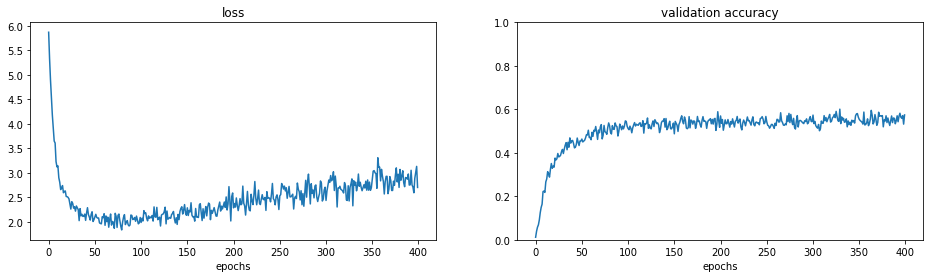

C:\Users\josed\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 2.864490270614624 ::::::::> Acc: 0.554347813129425


In [15]:
Execute_Model()

In [22]:
Train_Model(train_dataset,val_dataset,188)

C:\Users\josed\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/188
20/20 [==============================] - 53s 2s/step - loss: 1.2498 - accuracy: 0.6460 - val_loss: 2.3790 - val_accuracy: 0.4440
Epoch 2/188
20/20 [==============================] - 45s 2s/step - loss: 1.1796 - accuracy: 0.6650 - val_loss: 2.1945 - val_accuracy: 0.4930
Epoch 3/188
20/20 [==============================] - 45s 2s/step - loss: 1.0629 - accuracy: 0.7050 - val_loss: 2.2590 - val_accuracy: 0.4910
Epoch 4/188
20/20 [==============================] - 46s 2s/step - loss: 1.1149 - accuracy: 0.6720 - val_loss: 2.3154 - val_accuracy: 0.5040
Epoch 5/188
20/20 [==============================] - 45s 2s/step - loss: 1.3488 - accuracy: 0.6309 - val_loss: 2.7465 - val_accuracy: 0.4360
Epoch 6/188
20/20 [==============================] - 45s 2s/step - loss: 1.0896 - accuracy: 0.6800 - val_loss: 2.5557 - val_accuracy: 0.4520
Epoch 7/188
20/20 [==============================] - 45s 2s/step - loss: 0.9794 - accuracy: 0.7150 - val_loss: 2.3607 - val_accuracy: 0.5050
Epoch 8/188
2

Epoch 59/188
20/20 [==============================] - 45s 2s/step - loss: 0.8165 - accuracy: 0.7420 - val_loss: 2.3044 - val_accuracy: 0.4920
Epoch 60/188
20/20 [==============================] - 45s 2s/step - loss: 0.8103 - accuracy: 0.7490 - val_loss: 2.3903 - val_accuracy: 0.4980
Epoch 61/188
20/20 [==============================] - 45s 2s/step - loss: 0.8891 - accuracy: 0.7230 - val_loss: 2.6570 - val_accuracy: 0.4710
Epoch 62/188
20/20 [==============================] - 45s 2s/step - loss: 0.8220 - accuracy: 0.7430 - val_loss: 2.5098 - val_accuracy: 0.5210
Epoch 63/188
20/20 [==============================] - 45s 2s/step - loss: 0.8704 - accuracy: 0.7382 - val_loss: 2.2214 - val_accuracy: 0.5330
Epoch 64/188
20/20 [==============================] - 45s 2s/step - loss: 0.7952 - accuracy: 0.7660 - val_loss: 2.3443 - val_accuracy: 0.5050
Epoch 65/188
20/20 [==============================] - 45s 2s/step - loss: 0.7590 - accuracy: 0.7710 - val_loss: 2.4404 - val_accuracy: 0.5140
Epoch 

20/20 [==============================] - 47s 2s/step - loss: 0.6525 - accuracy: 0.8100 - val_loss: 2.6632 - val_accuracy: 0.5460
Epoch 174/188
20/20 [==============================] - 46s 2s/step - loss: 0.6555 - accuracy: 0.7960 - val_loss: 2.4613 - val_accuracy: 0.5330
Epoch 175/188
20/20 [==============================] - 46s 2s/step - loss: 0.5964 - accuracy: 0.8060 - val_loss: 2.5658 - val_accuracy: 0.5240
Epoch 176/188
20/20 [==============================] - 47s 2s/step - loss: 0.6707 - accuracy: 0.8070 - val_loss: 2.8509 - val_accuracy: 0.5000
Epoch 177/188
20/20 [==============================] - 46s 2s/step - loss: 0.6477 - accuracy: 0.8110 - val_loss: 2.5023 - val_accuracy: 0.5330
Epoch 178/188
20/20 [==============================] - 47s 2s/step - loss: 0.6152 - accuracy: 0.8120 - val_loss: 2.3332 - val_accuracy: 0.5520
Epoch 179/188
20/20 [==============================] - 47s 2s/step - loss: 0.5768 - accuracy: 0.8290 - val_loss: 2.5114 - val_accuracy: 0.5460
Epoch 180/188

In [16]:
model.save('model(ResNetv2)_e400.h5')

# Load Model

In [16]:
Compile_Model()

In [17]:
model.load_weights('model(ResNetv2)_e400.h5')

In [71]:
Evaluate_Model(test_dataset)

C:\Users\josed\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 2.896606922149658 ::::::::> Acc: 0.5522752404212952


# Model Analisys

In [72]:
res = model.predict(test_dataset)
res.shape

(8197, 291)

In [74]:
res2 = model.predict_classes(test_dataset)
res2.shape

(8197,)

In [76]:
res2

array([272, 250, 132, ..., 153, 154,  76], dtype=int64)

In [75]:
y_pred = np.argmax(res, axis=1)
y_true = np.array(test_dataset.labels, dtype='int64')
print(y_pred)
print(y_true)

[272 250 132 ... 153 154  76]
[  0   0   0 ... 290 290 290]


In [77]:
sum(res2==y_pred)

8197

In [80]:
resul = y_pred == y_true
sum(resul)

4527

In [78]:
print(test_dataset.class_indices)

{'1035167': 0, '1035185': 1, '1035194': 2, '1035195': 3, '1035204': 4, '1035208': 5, '1035231': 6, '1035290': 7, '1035366': 8, '1035434': 9, '1035542': 10, '1035551': 11, '1035578': 12, '1035864': 13, '1035929': 14, '1035931': 15, '1036066': 16, '1036128': 17, '1036154': 18, '1036192': 19, '1036203': 20, '1036216': 21, '1036255': 22, '1036286': 23, '1036789': 24, '1036796': 25, '1036893': 26, '1036899': 27, '1036917': 28, '1036958': 29, '1037293': 30, '1037319': 31, '1037633': 32, '4308786': 33, '4308787': 34, '4308789': 35, '4308790': 36, '4308800': 37, '4308801': 38, '4308804': 39, '4308805': 40, '4308806': 41, '4308807': 42, '4308811': 43, '4308812': 44, '4308815': 45, '4470539': 46, '4470555': 47, '4470765': 48, '4470801': 49, '4471071': 50, '4471113': 51, '4471202': 52, '4471235': 53, '4471238': 54, '4471269': 55, '4472828': 56, '4472849': 57, '4472858': 58, '4472884': 59, '4472897': 60, '4472900': 61, '4472907': 62, '4472913': 63, '4472929': 64, '4473127': 65, '4473277': 66, '447

In [79]:
class_labels = list(test_dataset.class_indices.keys())
print(class_labels)

['1035167', '1035185', '1035194', '1035195', '1035204', '1035208', '1035231', '1035290', '1035366', '1035434', '1035542', '1035551', '1035578', '1035864', '1035929', '1035931', '1036066', '1036128', '1036154', '1036192', '1036203', '1036216', '1036255', '1036286', '1036789', '1036796', '1036893', '1036899', '1036917', '1036958', '1037293', '1037319', '1037633', '4308786', '4308787', '4308789', '4308790', '4308800', '4308801', '4308804', '4308805', '4308806', '4308807', '4308811', '4308812', '4308815', '4470539', '4470555', '4470765', '4470801', '4471071', '4471113', '4471202', '4471235', '4471238', '4471269', '4472828', '4472849', '4472858', '4472884', '4472897', '4472900', '4472907', '4472913', '4472929', '4473127', '4473277', '4473297', '4473319', '4473320', '4473617', '4473795', '4473834', '4473860', '4473874', '4473903', '4473974', '4474146', '4474169', '4474653', '4474780', '4474861', '4474974', '4474998', '4475099', '4475127', '4475128', '4475140', '4475157', '4475179', '4475181'

In [36]:
len(class_labels)

291

In [81]:
print (classification_report(y_true,y_pred,target_names=class_labels))

              precision    recall  f1-score   support

     1035167       0.60      0.50      0.55        30
     1035185       0.60      0.50      0.55        30
     1035194       0.50      0.57      0.53        30
     1035195       0.65      0.37      0.47        30
     1035204       0.53      0.70      0.60        30
     1035208       0.77      0.67      0.71        30
     1035231       0.45      0.57      0.50        30
     1035290       0.72      0.70      0.71        30
     1035366       0.57      0.71      0.63        17
     1035434       0.57      0.27      0.36        30
     1035542       0.85      0.77      0.81        30
     1035551       0.93      0.93      0.93        30
     1035578       0.50      0.23      0.32        30
     1035864       0.88      0.50      0.64        30
     1035929       0.64      0.25      0.36        28
     1035931       0.15      0.20      0.17        30
     1036066       0.41      0.40      0.41        30
     1036128       0.24    

In [82]:
accuracy_score(y_true,y_pred)

0.5522752226424301

In [83]:
report = classification_report(y_true,y_pred,output_dict=True)
dfa    = pd.DataFrame(report,index=None).T.drop('weighted avg,accuracy,macro avg'.split(",")).reset_index()
dfa

,index,precision,recall,f1-score,support
0,0,0.600000,0.500000,0.545455,30.0
1,1,0.600000,0.500000,0.545455,30.0
2,2,0.500000,0.566667,0.531250,30.0
3,3,0.647059,0.366667,0.468085,30.0
4,4,0.525000,0.700000,0.600000,30.0
...,...,...,...,...,...
286,286,0.666667,0.733333,0.698413,30.0
287,287,0.875000,0.933333,0.903226,30.0
288,288,0.892857,0.833333,0.862069,30.0
289,289,0.538462,0.466667,0.500000,30.0


In [113]:
dfa.to_csv('report.csv')

In [125]:
dfa.sort_values('precision', ascending=False)['class,index,precision,recall,f1-score,test-support,total-support,val-support,train-support'.split(',')].head(10).to_csv('reporttop10.csv', index=False,float_format= "%.2f")

In [126]:
dfa.sort_values('precision', ascending=True)['class,index,precision,recall,f1-score,test-support,total-support,val-support,train-support'.split(',')].head(10).to_csv('reportdown10.csv', index=False,float_format= "%.2f")

In [85]:
dfa['support'] = dfa['support'].astype('int')
dfa['class'] = dfa['index'].apply(lambda x: class_labels[int(x)])
dfa['val-support'] = dfa['index'].apply(lambda x: val_dataset.classes.count(int(x)))
dfa['train-support'] = dfa['index'].apply(lambda x: train_dataset.classes.count(int(x)))
dfa['test-support'] = dfa['index'].apply(lambda x: test_dataset.classes.count(int(x)))
dfa['total-support'] = dfa['train-support'] + dfa['val-support'] + dfa['support']
dfa = dfa[['class','index','precision', 'recall', 'f1-score', 'support','test-support', 'total-support','val-support', 'train-support']]

In [86]:
dfa.sort_values('precision')

,class,index,precision,recall,f1-score,support,test-support,total-support,val-support,train-support
18,1036154,18,0.125000,0.066667,0.086957,30,30,100,20,50
15,1035931,15,0.150000,0.200000,0.171429,30,30,100,20,50
21,1036216,21,0.153846,0.400000,0.222222,30,30,100,20,50
19,1036192,19,0.170213,0.266667,0.207792,30,30,100,20,50
38,4308801,38,0.178571,0.166667,0.172414,30,30,100,20,50
...,...,...,...,...,...,...,...,...,...,...
44,4308812,44,1.000000,0.133333,0.235294,30,30,100,20,50
211,6097865,211,1.000000,0.200000,0.333333,30,30,100,20,50
46,4470539,46,1.000000,0.809524,0.894737,21,21,68,13,34
162,5755954,162,1.000000,0.277778,0.434783,18,18,59,12,29


In [87]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[15,  1,  0, ...,  0,  0,  0],
       [ 0, 15,  0, ...,  0,  0,  0],
       [ 0,  0, 17, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 25,  0,  0],
       [ 0,  0,  0, ...,  0, 14,  0],
       [ 0,  0,  0, ...,  0,  0, 16]], dtype=int64)

In [168]:
def class_report(cm, classe):
    arr = []
   # result = pd.concat(result,f'{classe}')
    for i, e in enumerate(cm[classe]):
        if e>0:
            arr.append(([i, e]))
    result = pd.DataFrame(arr,columns=['class', 'number of images']).set_index('class')   
    
    return result

In [181]:
class_report(cm, 21)


,number of images
class,
16,1
17,1
19,1
20,3
21,12
22,1
37,1
39,1
67,1


In [ ]:
test_dataset  = test_datagen.flow_from_dataframe(validate, x_col='path_img', y_col='insect_gbif', batch_size=BS, shuffle=False, target_size=img_shape)

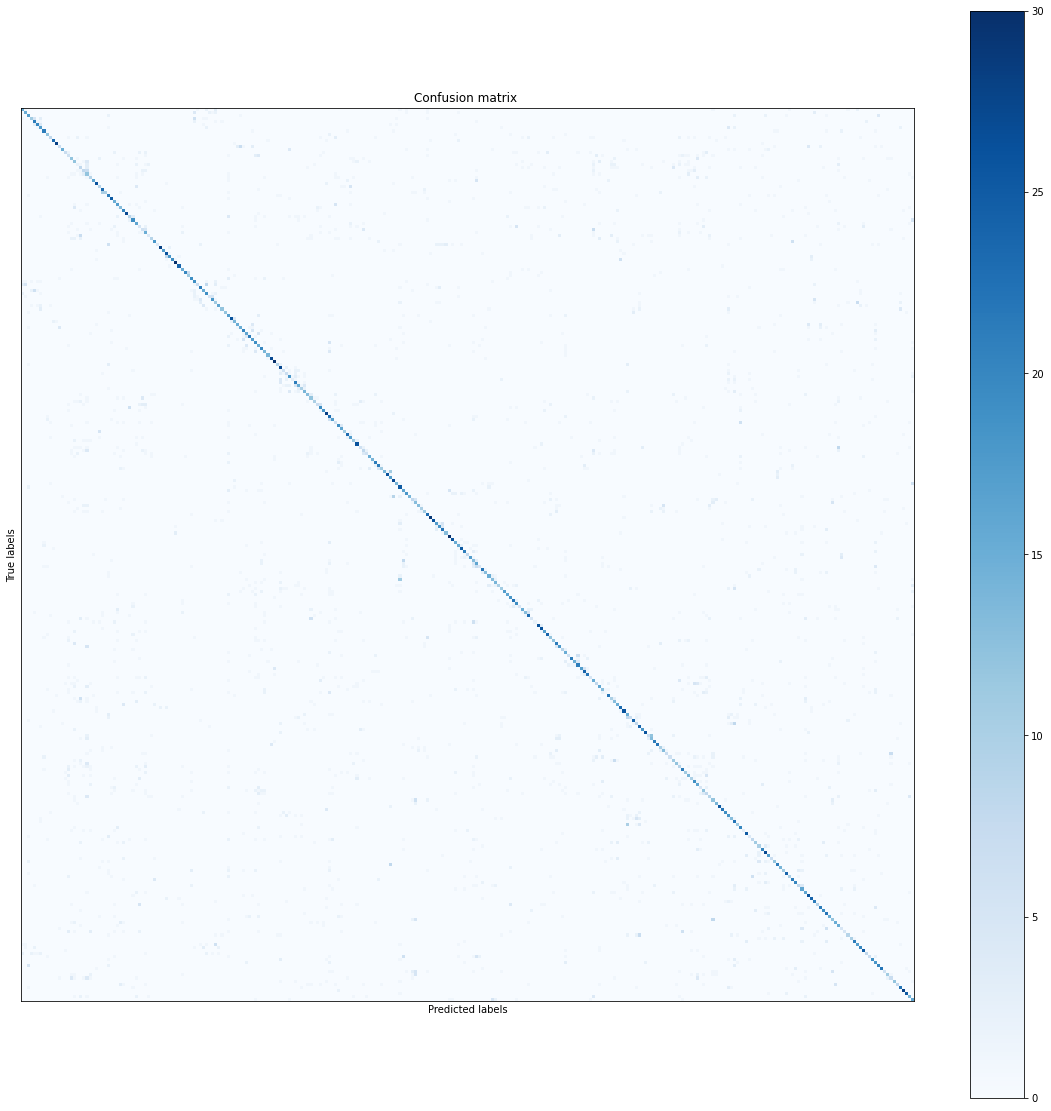

In [90]:
plt.figure(figsize = (20,20))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

In [27]:
test_dataset.class_indices

{'1035167': 0,
 '1035185': 1,
 '1035194': 2,
 '1035195': 3,
 '1035204': 4,
 '1035208': 5,
 '1035231': 6,
 '1035290': 7,
 '1035366': 8,
 '1035434': 9,
 '1035542': 10,
 '1035551': 11,
 '1035578': 12,
 '1035864': 13,
 '1035929': 14,
 '1035931': 15,
 '1036066': 16,
 '1036128': 17,
 '1036154': 18,
 '1036192': 19,
 '1036203': 20,
 '1036216': 21,
 '1036255': 22,
 '1036286': 23,
 '1036789': 24,
 '1036796': 25,
 '1036893': 26,
 '1036899': 27,
 '1036917': 28,
 '1036958': 29,
 '1037293': 30,
 '1037319': 31,
 '1037633': 32,
 '4308786': 33,
 '4308787': 34,
 '4308789': 35,
 '4308790': 36,
 '4308800': 37,
 '4308801': 38,
 '4308804': 39,
 '4308805': 40,
 '4308806': 41,
 '4308807': 42,
 '4308811': 43,
 '4308812': 44,
 '4308815': 45,
 '4470539': 46,
 '4470555': 47,
 '4470765': 48,
 '4470801': 49,
 '4471071': 50,
 '4471113': 51,
 '4471202': 52,
 '4471235': 53,
 '4471238': 54,
 '4471269': 55,
 '4472828': 56,
 '4472849': 57,
 '4472858': 58,
 '4472884': 59,
 '4472897': 60,
 '4472900': 61,
 '4472907': 62,
 '

# Best model

In [91]:
Compile_Model() 
model.load_weights(save_path+'best_model(ResNetv2).h5')  
model.summary()
Evaluate_Model(test_dataset)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 10, 10, 2048)      58331648  
_________________________________________________________________
MyMaxpool_1 (MaxPooling2D)   (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_7 (Dense)              (None, 291)              

C:\Users\josed\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 1.9388571977615356 ::::::::> Acc: 0.5201902985572815


In [92]:
y_pred = model.predict_classes(test_dataset)
y_true = np.array(test_dataset.labels, dtype='int64')
print(y_pred)
print(y_true)

C:\Users\josed\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[272 253 238 ... 290 290  87]
[  0   0   0 ... 290 290 290]


In [94]:
sum(y_pred == y_true)

4264

In [95]:
len(y_true)

8197

In [97]:
accuracy_score(y_true,y_pred)

0.52019031352934

In [96]:
report_b = classification_report(y_true,y_pred,output_dict=True)
dfa_b    = pd.DataFrame(report_b,index=None).T.drop('weighted avg,accuracy,macro avg'.split(",")).reset_index()
dfa_b

,index,precision,recall,f1-score,support
0,0,0.333333,0.433333,0.376812,30.0
1,1,0.404762,0.566667,0.472222,30.0
2,2,0.367647,0.833333,0.510204,30.0
3,3,0.333333,0.300000,0.315789,30.0
4,4,0.457143,0.533333,0.492308,30.0
...,...,...,...,...,...
286,286,0.777778,0.466667,0.583333,30.0
287,287,0.888889,0.800000,0.842105,30.0
288,288,0.962963,0.866667,0.912281,30.0
289,289,0.319149,0.500000,0.389610,30.0


In [99]:
dfa_b.sort_values('precision')

,index,precision,recall,f1-score,support
110,110,0.000000,0.000000,0.000000,30.0
15,15,0.139535,0.200000,0.164384,30.0
22,22,0.160714,0.300000,0.209302,30.0
214,214,0.200000,0.233333,0.215385,30.0
102,102,0.210526,0.400000,0.275862,30.0
...,...,...,...,...,...
50,50,1.000000,0.933333,0.965517,30.0
133,133,1.000000,0.433333,0.604651,30.0
137,137,1.000000,0.533333,0.695652,30.0
186,186,1.000000,0.100000,0.181818,30.0


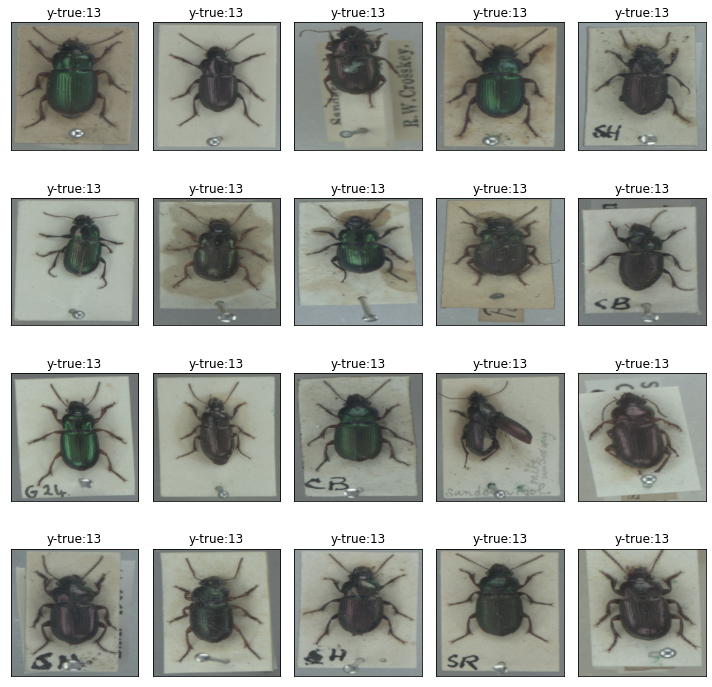

In [136]:
timgs, tlabs = next(test_dataset)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(timgs[i])
    ax.set_title("y-true:"+str(get_names(tlabs,i)) +"\n y_pred:"+str(model.predict(timgs[i])))
plt.tight_layout()
plt.show()